# Comparing Speeds of pandas and cuDF

In this notebook, we'll explore and analyze how much faster cuDF can be compared to a traditional pandas on data manipulation operations.

The task performed here is a simple one; for various orders of magnitude (called `data_size`, ranging from 10^3 to 10^8), we will:
1. Create a single-column DataFrame with `data_size` rows of numbers `[1, 2, 3, ...]`.
2. Apply a function to all rows; doubling the number in this row.

We will compare the time it takes for both pandas DataFrame and cuDF DataFrames to complete this task.


In [2]:
import cudf
import pandas as pd
import numpy as np
import time

In [3]:
pandas_times = []
cudf_times = []

exps = range(3, 9)

for exp in exps:
    data_length = 10**exp
    print("\ndata length: 1e%d" % exp)

    df = cudf.dataframe.DataFrame()
    df['in1'] = np.arange(data_length, dtype=np.float64)


    def kernel(in1, out):
        for i, x in enumerate(in1):
            out[i] = x * 2.0

    start = time.time()
    df = df.apply_rows(kernel,
                       incols=['in1'],
                       outcols=dict(out=np.float64),
                       kwargs=dict())
    end = time.time()
    print('cuDF time', end-start)
    cudf_times.append(end-start)
    assert(np.isclose(df['in1'].sum()*2.0, df['out'].sum()))


    df = pd.DataFrame()
    df['in1'] = np.arange(data_length, dtype=np.float64)
    start = time.time()
    df['out'] = df.in1.apply(lambda x: x*2)
    end = time.time()
    print('pandas time', end-start)
    pandas_times.append(end-start)
    
    assert(np.isclose(df['in1'].sum()*2.0, df['out'].sum()))



data length: 1e3
cuDF time 0.21628141403198242
pandas time 0.0016841888427734375

data length: 1e4
cuDF time 0.10938191413879395
pandas time 0.0023169517517089844

data length: 1e5
cuDF time 0.11726832389831543
pandas time 0.020251035690307617

data length: 1e6
cuDF time 0.11708641052246094
pandas time 0.19890308380126953

data length: 1e7
cuDF time 0.12265419960021973
pandas time 2.1786253452301025

data length: 1e8
cuDF time 0.16937804222106934
pandas time 22.41346549987793


In [4]:
results = cudf.DataFrame()
results["data_size"] = ["1e%d" % exp for exp in exps]
results["pandas_time"] = pandas_times
results["cudf_time"] = cudf_times
results["speedup"] = results["pandas_time"] / results["cudf_time"]

results

,data_size,pandas_time,cudf_time,speedup
0,1e3,0.001684,0.216281,0.007787
1,1e4,0.002317,0.109382,0.021182
2,1e5,0.020251,0.117268,0.172690
3,1e6,0.198903,0.117086,1.698772
4,1e7,2.178625,0.122654,17.762338
5,1e8,22.413465,0.169378,132.328047


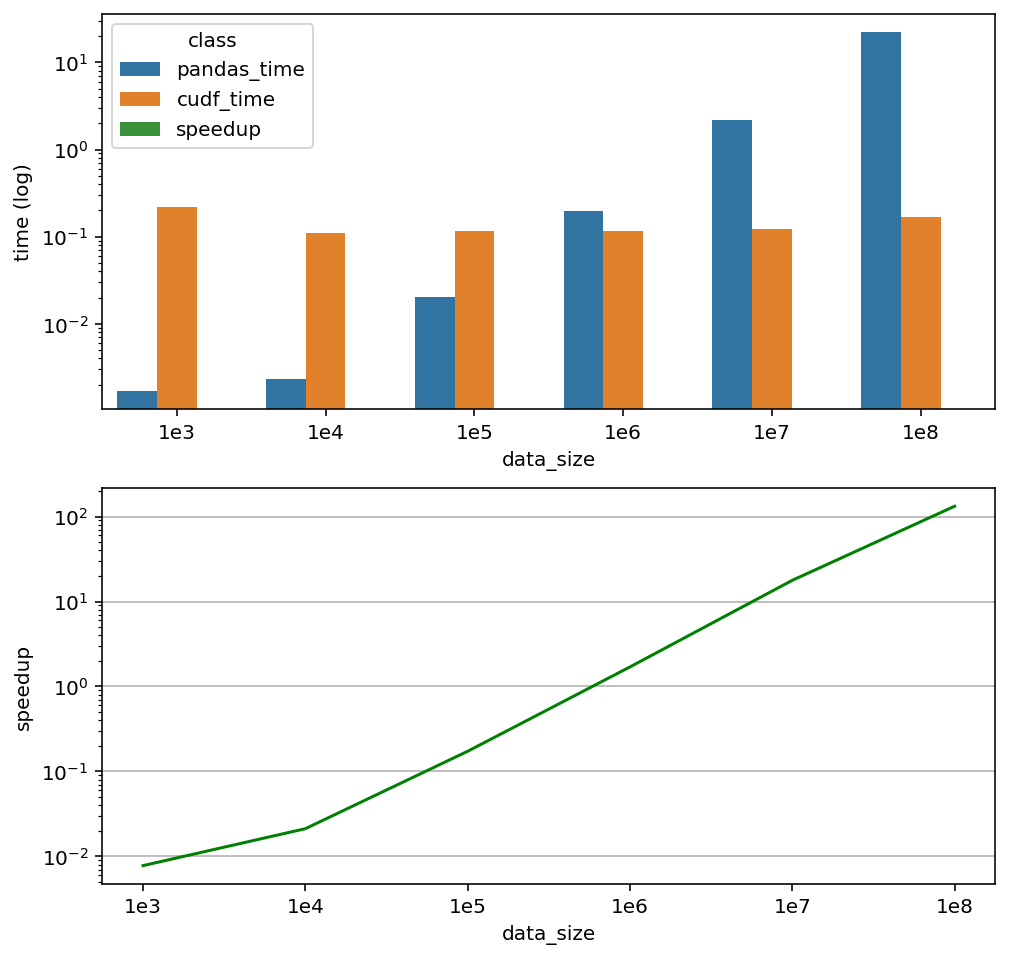

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib inline
%config InlineBackend.figure_format ='retina'

df = cudf.melt(results, id_vars=["data_size"], var_name="class", value_name="time")
df_time = df[df['class'] != "speedup"]
df_t2 = df_time.copy()

# We need to fall back to_pandas for plotting operations
f, ax = plt.subplots(2, 1, figsize=(8,8))
sns.barplot(x="data_size", y="time", hue="class", data=df_t2.to_pandas(), ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('time (log)')

sns.lineplot(x="data_size", y="speedup", data=results.to_pandas(), ax=ax[1], color='g')
ax[1].yaxis.grid()
ax[1].set_yscale('log')


plt.savefig("cuDF_vs_pandas.eps", format="eps", transparent=True)

# Takeaways

From the graph above, we can clearly see the choice you'll have to make when deciding to switch to GPU for your operations.

For relatively small size of data, the cost of moving this array into GPU memory is not worth the speed of processing that GPU offer, and you lose time. However, as data becomes bigger (10e6 and up), the parallelization capabilities of the GPU becomes really powerful and can speed up the operation up to **120** !